In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')
from vega_datasets import data

import pymc3 as pm
import theano.tensor as tt
import arviz as az

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [5]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

sklearn   : 0.23.2
arviz     : 0.10.0
theano    : 1.0.5
pymc3     : 3.9.3
pandas    : 1.1.3
matplotlib: 3.3.2
seaborn   : 0.11.0
numpy     : 1.19.2



### Data

In [6]:
iris = sns.load_dataset('iris')
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


<AxesSubplot:xlabel='sepal_length_z', ylabel='petal_width_z'>

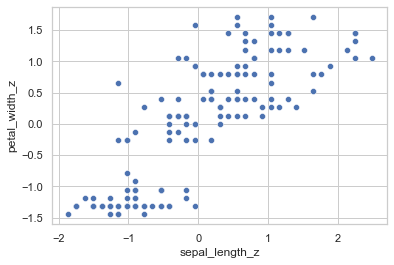

In [7]:
# standardize variables (much easier to think about priors etc on standard scale)
iris[['sepal_length_z','petal_width_z']] = StandardScaler().fit_transform(iris[['sepal_length','petal_width']])

sns.scatterplot(data=iris, x='sepal_length_z', y='petal_width_z')

### PyMC3 Model

In [8]:
# lifesaver for making predictions on new data
def model_factory(x_in, y_in):
    with pm.Model() as model:
        # data
        x = pm.Data('x', x_in)
        y = pm.Data('y', y_in)

        # priors on parameters
        α = pm.Normal('α', 0, 1)
        β = pm.Normal('β', 0, 1)
        σ = pm.HalfNormal('σ', 1)

        # model
        μ = pm.Deterministic('μ', β * x + α) # unnecessary to use `Deterministic` and probably inefficient - using this just for 'prettier' graph
        y_hat = pm.Normal('y_hat', mu=μ, sigma=σ, observed=y)
    return model

In [9]:
model = model_factory(iris['sepal_length_z'].values, iris['petal_width_z'].values)
model

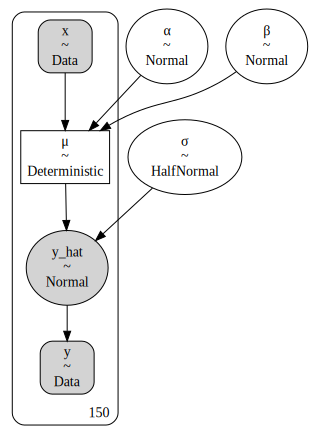

In [11]:
pm.model_to_graphviz(model)

In [12]:
with model:
    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive()
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(posterior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [13]:
inf_obj = az.from_pymc3(prior=prior, trace=posterior, posterior_predictive=posterior_pred,
                        model=model)
az.to_netcdf(inf_obj, 'model_11.netcdf')
inf_obj

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [14]:
inf_obj = az.from_netcdf('model_11.netcdf')
inf_obj

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [23]:
az.summary(inf_obj, var_names=['~μ'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,-0.000,0.050,-0.094,0.091,0.001,0.001,5301.0,1545.0,5301.0,2793.0,1.0
β,0.817,0.048,0.730,0.906,0.001,0.000,5094.0,5061.0,5085.0,3034.0,1.0
σ,0.582,0.033,0.520,0.645,0.000,0.000,5070.0,5070.0,5048.0,2761.0,1.0


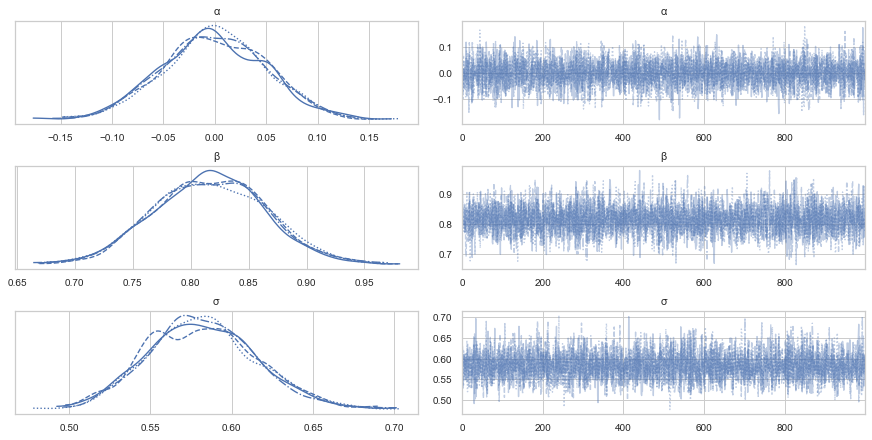

In [22]:
pm.traceplot(inf_obj, var_names=['~μ']);

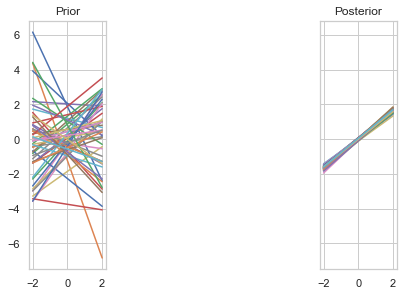

In [29]:
nshow = 50

samples = 500 # default n_samples in pymc3
idx = np.random.randint(0, samples, nshow)

fig, (ax1,ax2) = plt.subplots(ncols=2, sharey=True, constrained_layout=True, figsize=(8,4))
for α, β in zip(inf_obj.prior.get('α').values.flatten()[idx], 
                inf_obj.prior.get('β').values.flatten()[idx]):
    xs = np.linspace(-2, 2)
    ax1.plot(xs, β * xs + α)
ax1.set(title='Prior');

samples = 1000 # default n_samples in pymc3
idx = np.random.randint(0, samples, nshow)

for α, β in zip(inf_obj.posterior.get('α').values.flatten()[idx], 
                inf_obj.posterior.get('β').values.flatten()[idx]):
    xs = np.linspace(-2, 2)
    ax2.plot(xs, β * xs + α)
ax2.set(title='Posterior');

for ax in (ax1,ax2):
    ax.set(aspect='equal')

### sklearn Model

In [17]:
clf = LinearRegression()
clf.fit(iris[['sepal_length_z']], iris['petal_width_z'])

LinearRegression()

### Analysis and comparison

In [18]:
map_est = pm.find_MAP(model=model)

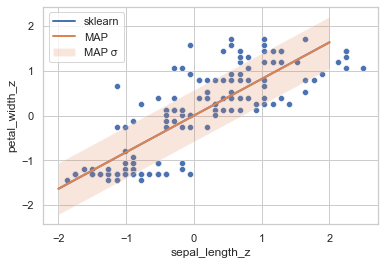

In [19]:
fig, ax = plt.subplots()

sns.scatterplot(data=iris, x='sepal_length_z', y='petal_width_z', ax=ax)

xs = np.linspace(-2, 2)
ax.plot(xs, clf.predict(xs[:,np.newaxis]), linewidth=2, label='sklearn')

ax.plot(xs, map_est['β'] * xs + map_est['α'], linewidth=2, label='MAP')
ax.fill_between(xs, 
                map_est['β'] * xs + map_est['α'] + map_est['σ'], 
                map_est['β'] * xs + map_est['α'] - map_est['σ'], 
                alpha=0.2, label='MAP σ')

ax.legend()

In [20]:
# dummy Y values are passed (these are not used for calculations but a vector of correct shape needs to be given here)
with model_factory(xs, np.zeros_like(xs)) as model_test:
    # use training trace to generate posterior samples on test set
    new_preds = pm.sample_posterior_predictive(posterior)

In [ ]:
fig, ax = plt.subplots()

sns.scatterplot(data=iris, x='sepal_length_z', y='petal_width_z', ax=ax)

hdi = az.hdi(new_preds['y_hat'], hdi_prob=0.89)
ax.fill_between(xs, hdi[:,0], hdi[:,1], alpha=0.3, color='C0', label='posterior 89% HDI')
ax.plot(xs, new_preds['y_hat'].mean(axis=0), color='C0', label='posterior')

ax.fill_between(xs, 
                map_est['β'] * xs + map_est['α'] + map_est['σ'], 
                map_est['β'] * xs + map_est['α'] - map_est['σ'], 
                alpha=0.2, color='C1', label='MAP σ')
ax.plot(xs, map_est['β'] * xs + map_est['α'], linewidth=2, color='C1', label='MAP')

# reorder legend
ax.legend();
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[0], handles[2], handles[1], handles[3]], 
          [labels[0], labels[2], labels[1], labels[3]]);

C:\Users\ruote\Anaconda3\envs\pymc\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
